# **LLM-based NER for historical lists: From semi-structured texts to structured data**


<style>
.full-width-banner {
    position: relative;
    left: 50%;
    right: 50%;
    margin-left: -50vw;
    margin-right: -50vw;
    width: 100vw;
    height: 300px;
    overflow: hidden;
    z-index: 1;
}
.full-width-banner img {
    width: 100%;
    height: 100%;
    object-fit: cover;
    display: block;
}
</style>

<div class="full-width-banner">
    <img src="https://raw.githubusercontent.com/nrastinger/llm-assisted-list-analysis/refs/heads/main/images/deco-banner-small.png" alt="Banner">
</div>

This Jupyter Notebook was initially created as part of a broader case study titled ["Visiting Vienna"](https://www.oeaw.ac.at/acdh/research/literary-textual-studies/research/linked-data-vienna-time-machine/visiting-vienna) that focused on **automatic information extraction from periodically published lists found in historical newspapers and advertising papers** (cf. [Rastinger 2024](https://doi.org/10.3384/ecp210016)). Specifically, it addressed the arrival lists published in the *Wien[n]erisches Diarium* (WD) from 1703 to 1725 and demonstrated how **Large Language Models (LLMs)** can be used for **Named Entity Recognition (NER)** to transform  historical semi-structured texts into structured data better suitable for analysis. With the idea of re-using this workflow for further (types of) lists, the Notebook has since been updated and further expanded. (Note: While the Notebook is optimized for seamless use in Google Colab — making it accessible without the need for extensive local setup — it can easily be adapted for local environments with minimal modifications.)

# **General Preparation**

Before use, the following preparations must be made:
*   **Input data** (= full texts of single lists or list items): prepared as either a folder with txt-files or a csv-file
*   **OpenAI API Acess**: OpenAI Account and API Key needed (stored in Colab Secrets as `"openai_api"`)
*   **Prompt Template** (`"prompt.jinja"`) is needed be stored in same folder as the Jupyter notebook

The easiest way to access the prompt template and exemplary data is to **clone the Github repository** by running the following cell (and then just leave the file paths as they are):

In [1]:
!git clone https://github.com/nrastinger/llm-assisted-list-analysis
%cd llm-assisted-list-analysis

fatal: destination path 'llm-assisted-list-analysis' already exists and is not an empty directory.
/content/llm-assisted-list-analysis


## Setting up necessary libraries and modules

The following cell makes sure all necessary Python libraries and modules and functions are installed and/or imported (Note: suggested restart of Notebook afterwards is optional).

In [2]:
# Installation of needed libraries and modules

!pip install promptify
!pip install nltk
!pip install seqeval
from promptify import Prompter, OpenAI, Pipeline
import pandas as pd
import re
import os
from google.colab import userdata, files
import json
import textwrap
from tabulate import tabulate
from collections import Counter
from itertools import count
from IPython.display import display, HTML
import xml.etree.ElementTree as ET
import nltk
from nltk.tokenize import RegexpTokenizer
from seqeval.metrics import accuracy_score
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score
from seqeval.metrics import precision_score
from seqeval.metrics import recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import copy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=586593aa1228551972c3d89853dc9a3d796c269e5cf55198c97396e6e7f67a8a
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


## Defining necessary functions

The following cell makes sure all necessary functions are defined.

In [42]:
# Functions for input text cleaning

def remove_empty_lines(text): #removes empty lines
    lines = text.splitlines()
    non_empty_lines = [line for line in lines if line.strip()]
    cleaned_text = '\n'.join(non_empty_lines)
    return cleaned_text

def clean(text, normalize_hyphens="no"): #basic cleaning of full texts; double hyphens can be normalized (= > -) or kept; default: kept
    if normalize_hyphens == "yes":
      cleaned = text.replace("=", "-")
      cleaned0 = remove_empty_lines(cleaned)
    else:
      cleaned0 = remove_empty_lines(text)
    cleaned_1 = re.sub("[=-]\\n(?=([a-z]|[üöäßéæ]))", "", cleaned0)
    cleaned_2 =  re.sub("[=-]\\n(?=[A-Z]|[ÄÖÜ])", "-", cleaned_1)
    cleaned_3 = re.sub("\\n", " ", cleaned_2)
    cleaned_4 = re.sub(" +", " ", cleaned_3)
    return cleaned_4.strip()

# Function for NER via Promptify

def ner(text, labels=None, examples=[], description=None, domain=None, usage_statistics=False):
    result = pipe.fit(text,
                      domain=domain,
                      examples=examples,
                      labels=labels,
                      description=description)

    completion = result[0]["parsed"]["data"]["completion"]

    # Normalize the structure in case of different output formats
    if isinstance(completion, list):
        if len(completion) > 0 and isinstance(completion[0], list):
            # If it's a list of lists, extract the first inner list
            normalized_completion = completion[0]
        else:
            # Already in the correct form
            normalized_completion = completion
    else:
        raise ValueError("Unexpected structure in completion data")

    # basic modus = only result
    if usage_statistics == False:
      return normalized_completion

    # detailed = result plus usage statistics
    elif usage_statistics == True:
      prompt_tokens = result[0]["usage"]["prompt_tokens"]
      completion_tokens = result[0]["usage"]["completion_tokens"]
      total_tokens = result[0]["usage"]["total_tokens"]
      return normalized_completion, prompt_tokens, completion_tokens, total_tokens

# Setting of default parameters - to avoid errors

labels=None
examples=[]
domain=None
usage_statistics=False

# Function for integrating entity IDs

def add_unique_entity_ids(df, entity_col="entities", id_key="id"):
    id_generator = count(1)

    def assign_ids(entities):
        if not isinstance(entities, list):
            return entities
        for entity in entities:
            if isinstance(entity, dict):
                entity[id_key] = f"e{next(id_generator)}"
        return entities

    df[entity_col] = df[entity_col].apply(assign_ids)
    return df

# Function for highlighting entities

def highlight_entities(row):
    text = row["text"]
    entities = row["entities"]

    if not isinstance(text, str) or not isinstance(entities, list):
        return HTML(text)

    # Sort and filter entities with positions
    entities = [e for e in entities if isinstance(e, dict) and "S" in e and "En" in e]
    entities.sort(key=lambda e: e["S"])

    result = ""
    last_idx = 0

    for entity in entities:
        s, en = entity["S"], entity["En"]
        etext = text[s:en]
        etype = entity.get("T", "Other")
        eid = entity.get("id", "")

        color = label_to_color.get(etype, "#dddddd")  # fallback color

        # Styled span for entity with mini pill for type & ID
        result += text[last_idx:s]
        result += (
            f'<span style="background-color:{color}; color:black; padding:3px 6px; '
            f'border-radius:16px; margin:0 2px; display:inline-block; '
            f'box-shadow: 1px 1px 3px rgba(0,0,0,0.1);">'
            f'{etext}'
            f'<span style="font-size:0.75em; font-weight:normal; margin-left:6px; '
            f'background-color:rgba(0,0,0,0.05); padding:1px 6px; border-radius:12px;">'
            f'{etype}, {eid}</span></span>'
        )
        last_idx = en

    result += text[last_idx:]
    return result

# Function for generating and exporting HTML file with displayed entities

def save_highlighted_entities_to_html(df, filename="output.html"):
    # Start HTML document
    html_parts = ["<html><body>"]

    # Generate HTML for each row
    for i, row in df.iterrows():
        html = highlight_entities(row)  # must return raw HTML string
        html_parts.append(f"<div>{html}</div><hr style='margin:30px 0;'>")

    # End HTML document
    html_parts.append("</body></html>")

    # Save to file
    with open(filename, "w", encoding="utf-8") as f:
        f.write("\n".join(html_parts))

    files.download(filename)

# Functions for importing goldstandard from CATMA export folder

def get_catma_annotations(base_folder, annotation_collection):
    annotations = []
    namespace = "{http://www.tei-c.org/ns/1.0}"  # TEI XML namespace
    xml_id_attr = "{http://www.w3.org/XML/1998/namespace}id"  # Correct namespace for xml:id

    for doc_folder in os.listdir(base_folder):
        doc_path = os.path.join(base_folder, doc_folder)

        # Ensure it's a directory (document subfolder)
        if os.path.isdir(doc_path):
            txt_file_path = None
            xml_file_path = os.path.join(doc_path, "annotationcollections", annotation_collection + ".xml")

            # Locate the TXT file in the document folder
            for file in os.listdir(doc_path):
                if file.endswith(".txt"):
                    txt_file_path = os.path.join(doc_path, file)
                    break  # Stop after finding the first TXT file

            # Ensure both the TXT and XML files exist
            if txt_file_path and os.path.exists(xml_file_path):
                with open(txt_file_path, 'r', encoding='utf-8') as txt_file:
                    text_content = txt_file.read()

                tree = ET.parse(xml_file_path)
                root = tree.getroot()

                # Mapping annotation IDs to type IDs from <fs> elements
                fs_id_to_type = {}
                for fs in root.findall(f".//{namespace}fs"):
                    fs_id = fs.get(xml_id_attr)  # Using correct namespace for xml:id
                    fs_type = fs.get("type")
                    if fs_id and fs_type:
                        fs_id_to_type[fs_id] = fs_type

                # Mapping type IDs to their readable labels from <fsDecl> elements
                type_to_label = {}
                for fs_decl in root.findall(f".//{namespace}fsDecl"):
                    type_id = fs_decl.get(xml_id_attr)  # Using correct namespace for xml:id
                    label_elem = fs_decl.find(f"{namespace}fsDescr")
                    if type_id and label_elem is not None:
                        type_to_label[type_id] = label_elem.text

                # Extracting annotations
                for seg in root.findall(f".//{namespace}seg"):
                    ana = seg.get("ana")
                    ptr = seg.find(f".//{namespace}ptr")

                    if ptr is not None and ana:
                        ana = ana.lstrip("#")  # Remove "#" prefix
                        target = ptr.get("target")

                        if "#char=" in target:
                            start, end = map(int, target.split("#char=")[1].split(","))
                            segment_text = text_content[start:end]

                            # Get label by first mapping to type, then to a readable label
                            annotation_type = fs_id_to_type.get(ana, "Unknown")
                            label = type_to_label.get(annotation_type, "Unknown")

                            annotations.append({
                                "document": doc_folder,  # Using subfolder name as document identifier
                                "annotation_id": ana,
                                "label": label,
                                "start": start,
                                "end": end,
                                "entity": segment_text,
                                "text": text_content
                            })

    df_catma = pd.DataFrame(annotations)
    df_merged = merge_separated_annotations(df_catma)
    df_merged['entity'] = df_merged.apply(lambda row: correct_entity_text(row, base_folder), axis=1)
    df_merged['text'] = df_merged.apply(lambda row: correct_full_text(row, base_folder), axis=1)
    return df_merged

# Function for merging rows with the same annotation_id

def merge_separated_annotations(df_catma):
  merged_annotations = []
  for annotation_id, group in df_catma.groupby("annotation_id"):
      min_start = group["start"].min()
      max_end = group["end"].max()
      first_row = group.iloc[0]  # Taking the first row for other attributes
      merged_annotations.append({
          "document": first_row["document"],
          "annotation_id": annotation_id,
          "label": first_row["label"],
          "start": min_start,
          "end": max_end,
          "entity": first_row["entity"], # Placeholder until correction
          "text": first_row["text"]
      })

  df_merged = pd.DataFrame(merged_annotations)
  return df_merged

#Correcting the 'entity' column after merging
def correct_entity_text(row, base_folder):
  doc = row['document']
  start = row['start']
  end = row['end']

  # Finding the original text file
  file_path = base_folder + '/' + doc + '/' + doc + '.txt'
  with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
  return text[start:end]

#Correcting the 'text' column after merging
def correct_full_text(row, base_folder):
  doc = row['document']

  # Finding the original text file
  file_path = base_folder + '/' + doc + '/' + doc + '.txt'
  with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
  return text

# Functions for identifying the correct positions of entities

def add_positions_and_flag_ambiguities(row):
    text = row["text"]
    entities = row["entities"]

    if not isinstance(text, str) or not isinstance(entities, list):
        print("Invalid data types in:", row)
        return entities

    used_spans = []
    entities = copy.deepcopy(entities)
    ent_texts = [e.get("E") for e in entities if isinstance(e, dict)]
    pred_counts = Counter(ent_texts)
    actual_counts = {e: len(re.findall(rf'(?<![\w\-=\u2011]){re.escape(e)}(?![\w\-=\u2011])', text)) for e in set(ent_texts)}

    for entity in entities:
        if not isinstance(entity, dict):
            print("Invalid data types in:", row)
            continue

        etext = entity.get("E")
        if not isinstance(etext, str):
            print("Invalid data types in:", row)
            continue

        # Ambiguity check
        if actual_counts.get(etext, 0) > pred_counts.get(etext, 0):
            entity["ambiguous"] = True

        # Regex to find only full-word (bounded) occurrences (hyphens and underscores are the only type of interpunctuation not seen as word-boundaries)
        pattern = re.compile(rf'(?<![\w\-=\u2011]){re.escape(etext)}(?![\w\-=\u2011])')
        for match in pattern.finditer(text):
            start, end = match.span()
            if all(end <= s or start >= e for s, e in used_spans):
                entity["S"] = start
                entity["En"] = end
                used_spans.append((start, end))
                break
        else:
            print(f"Entity {entity} not found in row:", row)
            entity["not_found"] = True

    return entities

def find_entity_positions(df, text_col="text", entity_col="entities"):
    df[entity_col] = df.apply(add_positions_and_flag_ambiguities, axis=1)
    return df

# Function for checking if entity start and end point align with token boundaries
# Scans a DataFrame for misaligned entity spans and prints any issues

def check_for_misaligned_entities(df, text_col="text", entity_col="entities"):
    tokenizer = RegexpTokenizer(r'[\w\-=]+|[^\w\s]', flags=re.UNICODE)
    all_correct = True

    for idx, row in df.iterrows():
        text = row.get(text_col)
        entities = row.get(entity_col)

        if not isinstance(text, str) or not isinstance(entities, list):
            continue

        # Get token offsets
        tokens = tokenizer.tokenize(text)
        token_offsets = []
        offset = 0
        for token in tokens:
            start = text.find(token, offset)
            end = start + len(token)
            token_offsets.append((start, end))
            offset = end

        # Token boundary sets
        boundary_starts = {start for start, _ in token_offsets}
        boundary_ends = {end for _, end in token_offsets}

        # Check each entity
        misaligned = []
        for entity in entities:
            s = entity.get("S")
            e = entity.get("En")
            if not isinstance(s, int) or not isinstance(e, int):
                misaligned.append(entity)
                continue
            if s not in boundary_starts or e not in boundary_ends:
                misaligned.append(entity)

        # Report if needed
        if misaligned:
            print(f"\n❌ Misaligned entities in row {idx}:")
            for ent in misaligned:
                print(ent)
            all_correct = False
    if all_correct:
      print("No misaligned entities found.")

# Functions for transforming texts + entities (collected in a df) to iob-format

def tokenize_and_iob(text, span_dicts, overlap_tolerance=False):
    """
    Tokenizes the text using nltk and converts entity spans to IOB format.

    Args:
        text (str): The full input text.
        span_dicts (list of dict): Each dict contains 'S' (start), 'En' (end), 'T' (label).
        overlap_tolerance (bool): If True, allows partial overlap between token and entity span.

    Returns:
        tokens (list of str): Tokenized text.
        tags (list of str): Corresponding IOB tags.
    """
    tokens = tokenizer.tokenize(text)
    tags = ['O'] * len(tokens)

    # Get character offsets for each token
    offset = 0
    token_offsets = []
    for token in tokens:
        start = text.find(token, offset)
        end = start + len(token)
        token_offsets.append((start, end))
        offset = end

    # Assign IOB tags
    for span in span_dicts:
        ent_start = span['S']
        ent_end = span['En']
        label = span['T']
        first_token = True

        for i, (tok_start, tok_end) in enumerate(token_offsets):
            if overlap_tolerance:
                match = tok_end > ent_start and tok_start < ent_end  # any overlap
            else:
                match = tok_start >= ent_start and tok_end <= ent_end  # fully inside

            if match:
                prefix = 'B' if first_token else 'I'
                tags[i] = f'{prefix}-{label}'
                first_token = False

    return tokens, tags

def transform_to_iob(df, text_col="text", entity_col="entities", iob_col="iob", overlap_tolerance=False):

    def transform_row_to_iob(row):
        text = row[text_col]
        entities = row[entity_col]
        if not isinstance(text, str) or not isinstance(entities, list):
            return []
        tokens, tags = tokenize_and_iob(text, entities, overlap_tolerance)
        return tags

    df[iob_col] = df.apply(transform_row_to_iob, axis=1)
    return df

# Function for changing from one row per entity to one row per text (entities packed in list of dictionaries)
def transform_from_entity_to_text_level(df):
  # Create the entities list for each row
  df['entities'] = df.apply(lambda row: {
      'E': row['entity'],
      'T': row['label'],
      'id': row['annotation_id'],
      'S': row['start'],
      'En': row['end']
  }, axis=1)

  # Group by 'document' and aggregate entity_dicts
  df = df.groupby('document').agg({
      'entities': list,
      'text': 'first'  # Retain the text if needed
  }).rename(columns={'entities': 'entities'}).reset_index()

  return df

# Function for visualising sequeval metrics per category/label in a heatmap
def visualize_seqeval_report(report_text):
    # Parse the classification report text
    lines = report_text.strip().splitlines()
    start_index = next(i for i, line in enumerate(lines) if 'precision' in line.lower())

    label_lines = [
        line for line in lines[start_index + 1:]
        if not line.strip().startswith(('micro', 'macro', 'weighted')) and line.strip()
    ]

    data = []
    for line in label_lines:
        parts = line.strip().split()
        if len(parts) >= 4:
            label = " ".join(parts[:-4])
            precision, recall, f1, support = parts[-4:]
            data.append([label, float(precision), float(recall), float(f1), int(support)])

    df = pd.DataFrame(data, columns=["Label", "Precision", "Recall", "F1-Score", "Support"])
    df.set_index("Label", inplace=True)

    # Define the color map: red → yellow → green
    cmap = sns.color_palette("RdYlGn", as_cmap=True)

    # Plot heatmap
    plt.figure(figsize=(10, len(df) * 0.5 + 1))
    ax = sns.heatmap(
        df[["Precision", "Recall", "F1-Score"]],
        annot=True,
        cmap=cmap,
        fmt=".2f",
        linewidths=0.5,
        linecolor='white',
        cbar_kws={"label": "Score"}
    )

    # Reverse the x-axis label position to the top
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.set_ylabel("Entity Label", fontsize=12)

    # Rotate ticks
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# **Upload and preprocessing**

As a first step, the data must be loaded. One input text can either be constituted by a **single list or a single list item**. However, a consistent choice within the data set is important.

Input texts can be either uploaded as **separate txt-files from a shared folder** ([Option 1](#scrollTo=0wirvBzB9yHT)) or from a **csv-file** ([Option 2](#scrollTo=H-WFwDcg-XVK)).

Depending on the data, **optional preprocessing steps** are recommended: In case the texts contain line-breaks, additional spaces or other digitisation artefacts, **cleaning** (cf. [here](#scrollTo=2jSFoR-h_h7M)) is recommended, and in case the texts are relatively long,  comparing their length with current LLM length limits and/or **splitting** them into multiple parts (cf. [here](#scrollTo=fnmRugLfAQqn)) can be helpful before NER.

## Option 1: Upload from folder
= Each input text is collected in a folder as an individual txt-file (encoding: UTF-8), clearly differentiated by its unique file name (used as `"id"`).

In [5]:
folder_path = "/content/llm-assisted-list-analysis/example-data/input-texts/WD-arrival-lists"  #Set to folder containing the text file❗️

ids = []
texts = []

for file_name in os.listdir(folder_path):
    if file_name.endswith('.txt'):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
        key = os.path.splitext(file_name)[0]
        ids.append(key)
        texts.append(content)

# Create DataFrame
data = pd.DataFrame({'id': ids, 'text': texts})
data.head()

,id,text
0,1724-05-10_cleaned,Ankunft deren Hoch- und Niedern Stands-Persone...
1,1714-10-20_cleaned,Ankunft derer Hoh- und Nieder den Stands-Perso...
2,1715-07-03_cleaned,Ankunft derer Hoh- und Niederen Stands-Persone...
3,1708-11-07_cleaned,Ankunfft derer Hoch- und nideren Stands-Persoh...
4,1705-08-22_cleaned,Ankunfft aller Hoch- und niedrigen Stands-Pers...


## Option 2: Upload from csv

= All input texts and their metadata are given in form of a csv-file, where the column **"id"** (string) contains an unique identifier and the column **"text"** (string) contains the text itself. Further columns with additional metadata are allowed.

In [6]:
csv_path = "/content/llm-assisted-list-analysis/example-data/input-texts/RD-arrival-list-entries.csv" #Set to path of csv file❗️
data = pd.read_csv(csv_path)
data.head()

,paragraph_id,type,coords,text,document,id
0,tr_1739890330,paragraph,"30,398 734,399 727,421 30,421","Den 9. per ord. Postwagen nach Laber, Hr. Tira...",6981872_3.xml,6981872_3_tr_1739890330
1,tr_1739890322,paragraph,"37,191 752,191 752,237 36,240","Den 27 Jnn. kommt zu Wasser von Neuburg, Tit. ...",6981872_4.xml,6981872_4_tr_1739890322
2,tr_1739890327,paragraph,"43,328 757,325 755,387 41,395","Den 3ten von Ulm, Msr. Tiers, Lieut. und Msr. ...",6981872_4.xml,6981872_4_tr_1739890327


## Optional: Cleaning of full texts

The function **clean()** takes care of the following **preprocessing steps**:
*   Removal of empty lines
*   Removal of line breaks
*   Merging of words seperated by line break - handled case-sensitive:
    *   hyphen is kept if upper case after line break (e.g. `"Stadt=\nTor"` > `"Stadt=Thor"`)
    *   hyphen is removed if lower case after line break (e.g. `"be=\ngleiten"` > `"begleiten"`)
* Normalization of hyphens:
    * default setting: single ("-") and double hyphens ("=") are preserved (`normalize_hyphens=False`)
    * for transforming all double hyphens into single hyphens: `normalize_hyphens=True`

In [7]:
# Taking an exemplary look: Comparing original vs. cleaned text

text = data.iloc[0]['text'] # Getting the first text of the DataFrame - change index number to see another text
print(f"Original text:\n{text}")
cleaned_text = clean(text, normalize_hyphens=False) # normalize_hypens can be set to True or False
print(f"\nCleaned text:\n{cleaned_text}")

Original text:
Den 9. per ord. Postwagen nach Laber, Hr. Tirant, Hochfürstl. Taxischer Zahnarzt.

Cleaned text:
Den 9. per ord. Postwagen nach Laber, Hr. Tirant, Hochfürstl. Taxischer Zahnarzt.


In [8]:
# Cleaning all uploaded texts
data['text'] = data['text'].apply(lambda x: clean(x, normalize_hyphens="no"))
data.head() # Preview of cleaned data

,paragraph_id,type,coords,text,document,id
0,tr_1739890330,paragraph,"30,398 734,399 727,421 30,421","Den 9. per ord. Postwagen nach Laber, Hr. Tira...",6981872_3.xml,6981872_3_tr_1739890330
1,tr_1739890322,paragraph,"37,191 752,191 752,237 36,240","Den 27 Jnn. kommt zu Wasser von Neuburg, Tit. ...",6981872_4.xml,6981872_4_tr_1739890322
2,tr_1739890327,paragraph,"43,328 757,325 755,387 41,395","Den 3ten von Ulm, Msr. Tiers, Lieut. und Msr. ...",6981872_4.xml,6981872_4_tr_1739890327


## Optional: Checking and adapting text length

Each LLM is limited to a certain **maximum number of tokens that can be processed in a single request**, including both the input (prompt) and the output (generated text). Although these limits are getting larger and larger with new LLM generations, you might want to check if your texts' length does not exceed the limit of the model you want to use. Also, keep in mind that LLM tokens do not equal traditional white-space token counts. To understand the difference and learn about current limits, check out: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them

You can also use the Tokenizer tool to measure the LLM token length of your input texts for a quick estimation: https://platform.openai.com/tokenizer (Note: Besides the input text itself, further needed tokens for prompt, e.g. examples, and output must also be taken into consideration.)

In [ ]:
# Identifying the longest text (in white-space tokens)
longest_text = data.loc[data['text'].str.len().idxmax()]
print(f"Length of longest text (ID: {longest_text['id']}): {len(longest_text['text'].split())} white-space tokens")
print(f"{longest_text['text']}")

In [ ]:
# WIP: Using tiktoken for token estimation

In [ ]:
# WIP: Splitting texts with a certain length into multiple parts

# **Named Entity Recognition (NER)**

Due to their differences to 'normal' news or texts (e.g. less syntax, higher entity density), lists often pose a challenge for non-generative pre-trained models, e.g. Early High German models on [Huggingface](https://huggingface.co/), which are usually trained on more prototypical data. Additionally, list entries often contain highly specific types of entities.

In this Notebook, LLMs are used for **automatically extracting (!) named entities within lists** (for extraction vs. annotation of NEs, cf. [Rastinger 2024](https://agki-dh.github.io/pages/webinar/page-7.html)). Among other things, this approach is helpful for low-resource scenarios such as the analysis of specific types of lists, as it allows for high flexibility and eliminates the need for an extensive annotated training set. To be more concrete, the case study "Visiting Vienna" used the **OpenAI API model "gpt-3.5-turbo"** via the **Python Library [Promptify](https://github.com/promptslab/Promptify)** which is also used in this Notebook.

## Setting up the LLM pipeline and choosing the model

The default model chosen in Promptify is "gpt-3.5-turbo". Alternatively the following OpenAI models can be used by changing the value of the argument `"model"`:

*   "text-davinci-003"
* "davinci"
* "text-davinci-001"
* "ada"
*   "text-curie-001"
*   "text-ada-001"
* "text-babbage-001"
* "curie"
* "text-davinci-002"
* "gpt-4-0314"
* "gpt-3.5-turbo-16k-0613"
* "gpt-3.5-turbo-0301"
* "gpt-3.5-turbo-16k"
* "gpt-4"
* "gpt-3.5-turbo"
* "gpt-3.5-turbo-0613"
* "gpt-4-0613"

Note that availability is dependent on OpenAI and may be subject to change. Besides OpenAI models, models from [HuggingFace](https://huggingface.co/) can also be called via `HubModel()`.

In [9]:
api_key = userdata.get('openai_api') # OpenAI API key needs to have been saved in Colab Secrets as "openai_api" plus access to this key needs to be granted for the Notebook ❗️
model = OpenAI(api_key, model="gpt-3.5-turbo") # Choose model ❗️
prompter = Prompter('/content/llm-assisted-list-analysis/prompt-templates/prompt.jinja') # Adapt to path to your jinja-file if repo is not loaded❗️
pipe = Pipeline(prompter, model)

## Setting NER parameters

Besides choosing the model, users can decide on many other aspects when using LLMs for NER, e.g. on defining (1) [annotation categories or labels](#scrollTo=zwZjXQktVaIQ), (2) [examples](#scrollTo=QBS3krOpRJO3), (3) [text domain](#scrollTo=tm1HoUKxTG0U) and various [other factors](#scrollTo=ZyjzZ0RMRiex). These parameters are explained in more details below where they can also be set if desired. (Note: All parameters are optional.)

### Categories or Labels

One of the main advantages of using LLMs for list analysis, instead of pre-trained Named Entity Recognizers, is the **free choice of labels**. Lists frequently follow a highly specific structure and thus benefit from the possibility of more **fine-grained entity types** (e.g. for arrival lists: "place of destination", "place of accomodation", "city gate" etc. instead of overarching "place"). The chosen labels are defined as a **list of strings**:


In [11]:
labels = ["Person", "Stadttor", "Datum", "Herkunftsort", "Unterkunftsort", "Zielort"] # German Labels used in the Case Study - adapt accordingly ❗️

### Examples

LLMs can make use of exemplary input-output-pairs (so-called
**"In-Context-Learning"**). Three main approaches are usually differentiated here:

1.   **Zero-shot** = no examples are given
2.   **One-shot** = one example is given
3. **Few-shot** = two or more examples are given

Based on my own experiences and a small literature-review (cf. [Rastinger 2024](https://agki-dh.github.io/pages/webinar/page-7.html)), it is **recommended to include examples**. To be used with this notebook, they must be given in the following format:
`[input-text[{"E": entity1, "T": label1}, {"E": entity2, "T": label2}, ...]]`

Depending on the desired result, the dictionary keys can be changed (e.g. `"E"` > `"Entity"`) and expanded freely, e.g. by additionally asking for start and end character (`"S"`, `"En"`). In this case, the `"prompt.jinja"` file must be changed accordingly. Also, note that **character positions generated by LLMs are usually hallucinated**, meaning they only constitute very rough estimates of the actual positions, and thus must be corrected during post-processing (cf. [here](#scrollTo=tHvejqWS_i7m)).

In general, the most important thing is, again, **consistency**: The labels assigned to the examples should be present within the defined set of labels. Also, ideally, all labels are present within the examples.

For the arrival lists of the *Wien[n]erisches Diarium*, two sets of examples (with and without character positions) are given in accompanying json-files ("example_WD_with_positions.json" and "example_WD_without_positions.json"). For easy experimentation with multiple example sets, own examples can either be added as json-files or hard-coded directly into the notebook:

In [14]:
# Use WD examples without positions
with open("/content/llm-assisted-list-analysis/example-data/in-context-learning/WD_arrival_lists_without_positions.json", "r", encoding="utf-8") as file:
    examples = json.load(file)

In [ ]:
# Use WD examples with positions
with open("/content/llm-assisted-list-analysis/example-data/in-context-learning/WD_arrival_lists_with_positions.json", "r", encoding="utf-8") as file:
    examples = json.load(file)

In [ ]:
# Upload own examples
with open("example-path", "r", encoding="utf-8") as file: # Replace with path to json file ❗️
    examples = json.load(file)

In [ ]:
# Hard-code own examples
examples = ["This example is an example text.",[{"E": "example", "T": "example"}, {"E": "example", "T": "example"}]] # Replace with actual examples ❗️

### Text Domain

Although not used in the case study, the domain of the input texts can be described freely (e.g. `"medical"`, `"news"`, `"literature"`) by setting the `domain` parameter:

In [ ]:
domain = "news" # Add text domain here ❗️

### Further parameters

Using the `prompt.jinja` file, Promptify builds the prompt based on your set of parameters. Further adaptions are thus possible by directly changing this file. For instance, by default, **role prompting** is employed (`"You are a highly intelligent and accurate Named Entity Recognition (NER) system."`), but can optionally be avoided by deleting this sentence in the `prompt.jinja` file. For more general information on **Prompt Engineering**, cf. [Pollin 2024](https://agki-dh.github.io/pages/webinar/page-3.html) and [Prompt-Engineering-Guide](https://github.com/dair-ai/Prompt-Engineering-Guide).

Besides adapting the prompt, further arguments can be set when setting up the LLM pipeline, e.g. `temperature` or `top_p`. For more details, cf. [Promptify](https://github.com/promptslab/Promptify/blob/main/promptify/models/text2text/api/openai_models.py) and [OpenAI Docs](https://platform.openai.com/docs/api-reference/responses/create).


## Running Named Entity Recognition - on individual lists

To quickly gain first insights of actual results, the following cells allow for an overview of the currently set parameters and running NER on single selected texts.

In [12]:
# Optional: Getting an overview of currently chosen parameters

for var_name in ['labels', 'examples', 'description', 'domain']:
    if var_name in locals() and locals()[var_name] != [] and locals()[var_name] != None:
        print(f"{var_name.capitalize()} defined: {locals()[var_name]}")
    else:
        print(f"No {var_name.capitalize()} defined")

Labels defined: ['Person', 'Stadttor', 'Datum', 'Herkunftsort', 'Unterkunftsort', 'Zielort']
Examples defined: [['Ankunfft aller Hoch- und nidrigen Stands Persohnen. Den 25. May. Rothen-Thurn. Herr Graff Rechtern Almelo / Holländis. Gesandter / kombt von Regenspurg / logirt im Sintzendorffis. Garten. Den 26. dito. Herr Obrist Baron Hauben / kombt von Prag / logirt beym Herrn Baron Greiff. Stuben-Thor. Herr Eberhard Ubermüller von Hemmengen / Hauptman vom Neuburgis. Regiment / kombt auß Ungarn / logirt im Jägerhorn. Cärntner-Thor. Herr General Adjutant vom Cusanis. Regiment / kombt auß Ungarn / logirt im Matschackerhoff. Den 27. dito. Cärntner-Thor. Herr Obrist-Wachtmeister Baron Decano vom Toletischen Regiment / kombt von Presburg / logirt im Rosenbergis. Hauß. Herr Obrist-Wachtmeister Wagner / vom Hannoveris. Regiment / kombt von Kützsee / logirt im Matschackerhoff. Stuben-Thor. Herr Obrist-Lieutenant Rothenhan / und Herr Rittmeister Weyß / beede vom Hohenzollneris. Regiment / kommen 

In [15]:
#Running NER on individual texts

# By default, the first text [0] is chosen - change index to choose another text
text = data.iloc[0]['text']

result = ner(text,
             labels=labels,
             examples=examples,
             domain=domain
             )

# Taking a look at the results
print("\n\n" + textwrap.fill(text, width=100) + "\n") # keeps text from running over the edge
for entity in result:
  print(entity)

100%|██████████| 1/1 [00:00<00:00, 131.22it/s]



Den 9. per ord. Postwagen nach Laber, Hr. Tirant, Hochfürstl. Taxischer Zahnarzt.

{'E': '9. per ord.', 'T': 'Datum'}
{'E': 'Laber', 'T': 'Zielort'}
{'E': 'Hr. Tirant', 'T': 'Person'}
{'E': 'Hochfürstl. Taxischer Zahnarzt', 'T': 'Person'}


Optional: By setting the `usage_statistics` argument to `True`, you can additionally get insights into certain **usage statistics**: (1) number of input tokens ("prompt tokens"), (2) number of output tokens ("completion tokens") and (3) total number of tokens needed.

In [17]:
text = data.iloc[0]['text']

result, prompt_tokens, completion_tokens, total_tokens = ner(text,
                                                            labels=labels,
                                                            examples=examples,
                                                            domain=domain,
                                                            usage_statistics = True # here is the change
                                                            )

print("\n\n" + textwrap.fill(text, width=100) + "\n")
for entity in result:
  print(entity)
print(f"\nPrompt tokens: {prompt_tokens}")
print(f"Completion tokens: {completion_tokens}")
print(f"Total tokens: {total_tokens}")

100%|██████████| 1/1 [00:00<00:00, 173.08it/s]



Den 9. per ord. Postwagen nach Laber, Hr. Tirant, Hochfürstl. Taxischer Zahnarzt.

{'E': '9. per ord.', 'T': 'Datum'}
{'E': 'Laber', 'T': 'Zielort'}
{'E': 'Hr. Tirant', 'T': 'Person'}
{'E': 'Hochfürstl. Taxischer Zahnarzt', 'T': 'Person'}

Prompt tokens: 1286
Completion tokens: 74
Total tokens: 1360


## Running Named Entity Recognition - on a larger batch of lists

In [18]:
# Choose outputs and statistics you'd like to get for each input text - default: all chosen
cols = ["entities", "prompt_tokens", "completion_tokens", "total_tokens"] # Delete unwanted columns ❗️

# Ensuring columns for each output exist in the dataframe
for col in cols:
    if col not in data.columns:
        data[col] = None

for idx in data.index:
  text = data.at[idx, "text"]

  result, prompt_tokens, completion_tokens, total_tokens = ner(
            text,
            labels=labels,
            examples=examples,
            domain=domain,
            usage_statistics=True) # Important: keep True!

  # Saving only selected outputs
  if "entities" in cols:
    data.at[idx, "entities"] = result
  if "prompt_tokens" in cols:
    data.at[idx, "prompt_tokens"] = prompt_tokens
  if "completion_tokens" in cols:
    data.at[idx, "completion_tokens"] = completion_tokens
  if "total_tokens" in cols:
    data.at[idx, "total_tokens"] = total_tokens

  # Saving after each row
  data.to_csv("ner_output_progress.csv", index=False)

100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


In [25]:
# Saving and downloading the results

data.to_csv('ner_results.csv', index=False)
files.download('ner_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Taking a look at the results

In [20]:
# Taking a look at the results
data

,paragraph_id,type,coords,text,document,id,entities,prompt_tokens,completion_tokens,total_tokens
0,tr_1739890330,paragraph,"30,398 734,399 727,421 30,421","Den 9. per ord. Postwagen nach Laber, Hr. Tira...",6981872_3.xml,6981872_3_tr_1739890330,"[{'E': '9. per ord.', 'T': 'Datum'}, {'E': 'La...",1286,74,1360
1,tr_1739890322,paragraph,"37,191 752,191 752,237 36,240","Den 27 Jnn. kommt zu Wasser von Neuburg, Tit. ...",6981872_4.xml,6981872_4_tr_1739890322,"[{'E': '27 Jnn.', 'T': 'Datum'}, {'E': 'Neubur...",1294,91,1385
2,tr_1739890327,paragraph,"43,328 757,325 755,387 41,395","Den 3ten von Ulm, Msr. Tiers, Lieut. und Msr. ...",6981872_4.xml,6981872_4_tr_1739890327,"[{'E': '3ten', 'T': 'Datum'}, {'E': 'Ulm', 'T'...",1323,155,1478


### Statistics on results

In [31]:
# Initialize totals
total_entities = 0
label_counts = {}

# Iterate over rows and count labels
for index, row in data.iterrows():
  entities = row['entities']
  if not entities or not isinstance(entities, list):
    continue  # Skip if empty or not a list
  total_entities += len(entities)
  for entity in entities:
    label = entity.get('T', 'Unknown')  # Use 'Unknown' if label is missing
    label_counts[label] = label_counts.get(label, 0) + 1

# Prepare results table
table_data = [
    (label, count, f"{(count / total_entities) * 100:.2f}%")
    for label, count in sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
]

# Print statistics
print(f"Total entities identified: {total_entities}")
print(tabulate(table_data, headers=["Label", "Count", "Percentage"], tablefmt="fancy_grid"))

**Total entities identified:** 18
╒════════════════╤═════════╤══════════════╕
│ Label          │   Count │ Percentage   │
╞════════════════╪═════════╪══════════════╡
│ Person         │       7 │ 38.89%       │
├────────────────┼─────────┼──────────────┤
│ Datum          │       3 │ 16.67%       │
├────────────────┼─────────┼──────────────┤
│ Herkunftsort   │       3 │ 16.67%       │
├────────────────┼─────────┼──────────────┤
│ Zielort        │       2 │ 11.11%       │
├────────────────┼─────────┼──────────────┤
│ Unterkunftsort │       2 │ 11.11%       │
├────────────────┼─────────┼──────────────┤
│ Stadttor       │       1 │ 5.56%        │
╘════════════════╧═════════╧══════════════╛


### Statistics on usage

In [22]:
# Token columns
usage_cols = ["prompt_tokens", "completion_tokens"]

# Calculate total from total_tokens column
total_tokens = data["total_tokens"].sum()

# Sum prompt and completion tokens separately
token_totals = {col: data[col].sum() for col in usage_cols}

# Prepare table with percentage of total_tokens
token_table = [
    (col, token_totals[col], f"{(token_totals[col] / total_tokens) * 100:.2f} %")
    for col in usage_cols
]

# Print the results
print(f"Total Tokens needed: {total_tokens}")
print(tabulate(token_table, headers=["Token Type", "Total", "Percentage"], tablefmt="fancy_grid"))

Total Tokens needed: 4223
╒═══════════════════╤═════════╤══════════════╕
│ Token Type        │   Total │ Percentage   │
╞═══════════════════╪═════════╪══════════════╡
│ prompt_tokens     │    3903 │ 92.42 %      │
├───────────────────┼─────────┼──────────────┤
│ completion_tokens │     320 │ 7.58 %       │
╘═══════════════════╧═════════╧══════════════╛


# **Postprocessing**

## Integrating entity IDs

For safer post-processing, each generated entity is given a **unique ID** (`"id"`). Among other things, this can later be used to easily correct errors and differentiate between linguistically identical entities.


In [23]:
data = add_unique_entity_ids(data)

# Taking a look at the difference in the first entity of the first text
print(data.loc[0, "entities"][0])

{'E': '9. per ord.', 'T': 'Datum', 'id': 'e1'}


## Identifying hallucinations

LLMs can **hallucinate**, meaning they may produce results that were not in the input. For NER, this can apply to both entities and labels and may vary from fully hallucinated results (e.g. not-defined label) to single-character differences (e.g. normalised writing), meaning certain hallucinations may - depending on the project goals - still be considered 'correct'. To allow for easy overview and integration, the following cells check for all divergences between in- and output and mark them through **designated columns** (`"hallucinated_labels"`, `"hallucinated_entities"`). Additionally, **statistics on hallucinations** can be generated.

### Hallucinated labels
(= labels not in the defined label set)

In [26]:
# Identifying hallucinated labels - only applicable if a set of labels was defined

# Function to check if all entity labels are in the label set
def check_entity_labels(entity_list, labels):
    if not entity_list:  # Skips unprocessed lists or empty outputs
        return []
    return [entity for entity in entity_list if entity.get("T") not in labels] # Returns list of invalid entities (empty = all valid)

# Apply to DataFrame
data["hallucinated_labels"] = data["entities"].apply(lambda ents: check_entity_labels(ents, labels))

data.head()

,paragraph_id,type,coords,text,document,id,entities,prompt_tokens,completion_tokens,total_tokens,hallucinated_labels
0,tr_1739890330,paragraph,"30,398 734,399 727,421 30,421","Den 9. per ord. Postwagen nach Laber, Hr. Tira...",6981872_3.xml,6981872_3_tr_1739890330,"[{'E': '9. per ord.', 'T': 'Datum', 'id': 'e1'...",1286,74,1360,[]
1,tr_1739890322,paragraph,"37,191 752,191 752,237 36,240","Den 27 Jnn. kommt zu Wasser von Neuburg, Tit. ...",6981872_4.xml,6981872_4_tr_1739890322,"[{'E': '27 Jnn.', 'T': 'Datum', 'id': 'e5'}, {...",1294,91,1385,[]
2,tr_1739890327,paragraph,"43,328 757,325 755,387 41,395","Den 3ten von Ulm, Msr. Tiers, Lieut. und Msr. ...",6981872_4.xml,6981872_4_tr_1739890327,"[{'E': '3ten', 'T': 'Datum', 'id': 'e10'}, {'E...",1323,155,1478,[]


In [27]:
# Generating statistics on hallucinated labels

# Count total number of predicted entities
total_entities = data["entities"].dropna().apply(len).sum()

# Count total number of hallucinated labels
total_hallucinated = data["hallucinated_labels"].dropna().apply(len).sum()

# Calculate hallucination percentage
percent_hallucinated = (total_hallucinated / total_entities * 100) if total_entities > 0 else 0

hallucinated_labels_ov = [
    ["Hallucinated labels", total_hallucinated],
    ["Total entities", total_entities],
    ["Percentage of hallucinated labels", f"{percent_hallucinated:.2f} %"]
]

print(tabulate(hallucinated_labels_ov, headers=["Metric", "Value"], tablefmt="fancy_grid"))

╒═══════════════════════════════════╤═════════╕
│ Metric                            │ Value   │
╞═══════════════════════════════════╪═════════╡
│ Hallucinated labels               │ 0       │
├───────────────────────────────────┼─────────┤
│ Total entities                    │ 18      │
├───────────────────────────────────┼─────────┤
│ Percentage of hallucinated labels │ 0.00 %  │
╘═══════════════════════════════════╧═════════╛


### Hallucinated entities
(= entities not included in exactly the same way in the input text; entities found more often than they appear in the input text are also counted as hallucinations)

In [28]:
# Identifying hallucinated entities

def check_entity_texts(entity_list, source_text):
    if not entity_list or not isinstance(entity_list, list) or not isinstance(source_text, str):
        return []

    # Extract predicted entity texts
    predicted_texts = [entity.get("E") for entity in entity_list if isinstance(entity, dict) and "E" in entity]
    predicted_counts = Counter(predicted_texts)

    # Count actual occurrences in the source text
    actual_counts = Counter()
    for text in predicted_texts:
        actual_counts[text] = source_text.count(text)

    # Identify hallucinated entities
    hallucinated_entities = []
    temp_counts = actual_counts.copy()
    for entity in entity_list:
        etext = entity.get("E")
        if etext is None:
            continue
        if temp_counts[etext] > 0:
            temp_counts[etext] -= 1
        else:
            hallucinated_entities.append(entity)

    return hallucinated_entities

# Apply to DataFrame
data["hallucinated_entities"] = data.apply(
    lambda row: check_entity_texts(row["entities"], row["text"]),
    axis=1
)

data.head()

,paragraph_id,type,coords,text,document,id,entities,prompt_tokens,completion_tokens,total_tokens,hallucinated_labels,hallucinated_entities
0,tr_1739890330,paragraph,"30,398 734,399 727,421 30,421","Den 9. per ord. Postwagen nach Laber, Hr. Tira...",6981872_3.xml,6981872_3_tr_1739890330,"[{'E': '9. per ord.', 'T': 'Datum', 'id': 'e1'...",1286,74,1360,[],[]
1,tr_1739890322,paragraph,"37,191 752,191 752,237 36,240","Den 27 Jnn. kommt zu Wasser von Neuburg, Tit. ...",6981872_4.xml,6981872_4_tr_1739890322,"[{'E': '27 Jnn.', 'T': 'Datum', 'id': 'e5'}, {...",1294,91,1385,[],[]
2,tr_1739890327,paragraph,"43,328 757,325 755,387 41,395","Den 3ten von Ulm, Msr. Tiers, Lieut. und Msr. ...",6981872_4.xml,6981872_4_tr_1739890327,"[{'E': '3ten', 'T': 'Datum', 'id': 'e10'}, {'E...",1323,155,1478,[],[]


In [29]:
# Statistics on hallucinated entities

# Count total number of predicted entities
total_entities = data["entities"].dropna().apply(len).sum()

# Count total number of hallucinated entities
total_hallucinated_entities = data["hallucinated_entities"].dropna().apply(len).sum()

# Calculate hallucination percentage
percent_hallucinated_entities = (
    (total_hallucinated_entities / total_entities * 100) if total_entities > 0 else 0
)

# Prepare results
hallucinated_entities_ov = [
    ["Hallucinated entities", total_hallucinated_entities],
    ["Total entities", total_entities],
    ["Percentage of hallucinated entities", f"{percent_hallucinated_entities:.2f}%"]
]

# Display as table
print(tabulate(hallucinated_entities_ov, headers=["Metric", "Value"], tablefmt="fancy_grid"))

╒═════════════════════════════════════╤═════════╕
│ Metric                              │ Value   │
╞═════════════════════════════════════╪═════════╡
│ Hallucinated entities               │ 0       │
├─────────────────────────────────────┼─────────┤
│ Total entities                      │ 18      │
├─────────────────────────────────────┼─────────┤
│ Percentage of hallucinated entities │ 0.00%   │
╘═════════════════════════════════════╧═════════╛


## Identifying positions of entities

Getting the **correct positions of NEs within input texts** (`"S"` = start character, `"En"` = end character) is valuable for annotating, visualising, verifying  and evaluating them. As mentioned, LLMs tend to hallucinate when asked for character start and end points - which is why this information needs to be added afterwards by finding generated entities with the input text. (Note: At this step of the workflow, i.e. without manual corrections or fuzzy matching, hallucinated entities can not be found in the input text. This will be solved in a later step.)

Tip: In case you asked the LLM for entity positions, you can also use the [display function](#scrollTo=Ha0Hrh1xlW-e) to take a look at possible non-alignments with actual entities.

**Ambigous positions:** What poses a challenge are the relatively rare cases in which certain words/NEs are appearing multiple times in an input text, but are only identified as an entity once. This can, for instance, occur, if whole lists that tend to repeatedly contain the same entities are used as input text. Here, it may be unclear which mention was actually identified. Currently, the Notebook marks such entities with multiple possible positions with `"ambiguous"=True`.

WIP: Based on the case study, so far, the only (approximation to a) solution for this problem seems to be taking into account (a) the order in which an LLM returns the entities as this usually corresponds to their in-text order and/or (b) the LLM-estimated positions. The code for these approaches is currently being updated and will be added to the Notebook in the future.

In [33]:
#Adding start ("S") and end ("En") to each entity
data = find_entity_positions(data)

# Taking a look at the difference in the first entity of the first text
print(data.loc[0, "entities"][0])

{'E': '9. per ord.', 'T': 'Datum', 'id': 'e1', 'S': 4, 'En': 15}


In [35]:
# Counting entities with "ambiguous"=True
ambiguous_count = 0
for index, row in data.iterrows():
    entities = row['entities'] # Assuming entities are stored as strings
    for entity in entities:
        if isinstance(entity, dict) and entity.get('ambiguous', False) == True:
            ambiguous_count += 1

print(f"Number of entities with ambiguous positions: {ambiguous_count}")

Number of entities with ambiguous positions: 0


In [ ]:
# WIP: optional: calculating statistics on difference between LLM-estimated and actual positions - in case the LLM was asked for entity positions as well

In [50]:
# WIP: optional: item separation based on entity types (e.g. certain type of entity marks end point of an item) - in case whole lists are used as input texts

# **Displaying results**

In [41]:
# Color palette - add more colors if more than six labels are used
colors = ['#F0D9EF', '#FCDCE1', '#FFE6BB', '#E9ECCE', '#CDE9DC', '#C4DFE5']

# Mapping each label from the label set to a color
# Labels not in the defined label set will be shown in grey
label_to_color = {label: colors[i % len(colors)] for i, label in enumerate(labels)}

for _, row in data.head(5).iterrows(): # showing first five examples by default - change if needed or download all below
    display(highlight_entities(row))
    print("-" * 80)

--------------------------------------------------------------------------------


--------------------------------------------------------------------------------


--------------------------------------------------------------------------------


In [51]:
# Downloading a HTML will all texts and their highlighted entities
save_highlighted_entities_to_html(data, filename="annotated_entities.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluation

For optional (but recommended!) evaluation of the NER results, the following cells allow for **comparison with a goldstandard data set**, prepared outside of the Notebook with [CATMA](https://catma.de/) or another annotation platform.

## Option 1: Uploading goldstandard created with CATMA

One option for creating a goldstandard data set is [CATMA (= Computer Assisted Text Markup and Analysis)](https://catma.de/) where users can (collaboratively) annotate texts according to their individual tag sets. To be used in this Notebook, the annotations of selected documents can be downloaded from within CATMA as a zip-folder, extracted (= unzipped) and, lastly, uploaded here.

To ensure compatability of NER results and goldstandard, the following things must be given:
- identical full texts (e.g. both cleaned)
- identical label set (i.e. defined in prompt vs. used for annotation)

In [52]:
folder_catma = "/content/llm-assisted-list-analysis/example-data/goldstandard/RD-catma-export" # Change to path to export results ❗️
annotation_collection = "NER" # Change to name of CATMA annotation collection ❗️

goldstandard = get_catma_annotations(folder_catma, annotation_collection)
goldstandard = transform_from_entity_to_text_level(goldstandard)
goldstandard.head()

,document,entities,text
0,tr_1739890322,"[{'E': 'Wasser', 'T': 'Mittel', 'id': 'CATMA_0...","Den 27 Jnn. kommt zu Wasser von Neuburg, Tit. ..."
1,tr_1739890327,"[{'E': 'gold. Adler', 'T': 'Unterkunftsort', '...","Den 3ten von Ulm, Msr. Tiers, Lieut. und Msr. ..."
2,tr_1739890330,"[{'E': 'ord. Postwagen', 'T': 'Mittel', 'id': ...","Den 9. per ord. Postwagen nach Laber, Hr. Tira..."


## Option 2: Uploading goldstandard from csv-file

Alternatively, the goldstandard can also be uploaded from a prepared csv-file, optimally in the same format as the NER output data. (Direct upload in IOB-format would theoretically also be feasible, however it is only recommended if the same tokenizer was used, since this would otherwise lead to misalignment.)

In [ ]:
goldstandard = pd.read_csv("goldstandard.csv") # Change to path to goldstandard as csv-file ❗️
goldstandard.head()

## Transformating NER output and goldstandard to IOB format

First, tokenisation (here: custom - each token ...; e.g. ...), then transformation to IOB-Format (IOB2); RegEx Tokenizer: möglichst einheitliche Behandlung von Abkürzungen etc., möglichst feingliedrig - jedes Satzzeichen (auch Abkürzungspunkte, ausgenommen Hyphen) als Token

In [53]:
# Setting up a costum tokenizer
tokenizer = RegexpTokenizer(r'[\w\-=]+|[^\w\s]', flags=re.UNICODE)

In [54]:
# Optional: Taking a look at how the tokenizer tokenizes
text = "Den 9. per ord. Postwagen nach Laber, Hr. Tirant, Hochfürstl. Taxischer Zahnarzt."
print(tokenizer.tokenize(text))

['Den', '9', '.', 'per', 'ord', '.', 'Postwagen', 'nach', 'Laber', ',', 'Hr', '.', 'Tirant', ',', 'Hochfürstl', '.', 'Taxischer', 'Zahnarzt', '.']


As mentioned before, LLMs tokenize differently - meaning they might also have followed other rules when extracting entities. e.g. misalignment:

by Default: not total overlap > ignored (= not found)
change setting --> overlapping allowed

In [55]:
# Checking for entities in the data whose start and end points misalign with token boundaries
check_for_misaligned_entities(data)

No misaligned entities found.


In [56]:
check_for_misaligned_entities(goldstandard)

No misaligned entities found.


In [57]:
# Optional: Taking a look at how the data is transformed to IOB format
text = "Den 9. per ord. Postwagen nach Laber, Hr. Tirant, Hochfürstl. Taxischer Zahnarzt."
span_dicts = [{'E': '9.', 'T': 'Datum', 'id': 'e1', 'S': 4, 'En': 6},{'E': 'Laber', 'T': 'Zielort', 'id': 'e2', 'S': 31, 'En': 36},{'E': 'Hr. Tirant', 'T': 'Person', 'id': 'e3', 'S': 38, 'En': 48},{'E': 'Hochfürstl. Taxischer Zahnarzt', 'T': 'Person', 'id': 'e4', 'S': 50, 'En': 80}]
tokens, tags = tokenize_and_iob(text, span_dicts)
print(tokens)
print(tags)

['Den', '9', '.', 'per', 'ord', '.', 'Postwagen', 'nach', 'Laber', ',', 'Hr', '.', 'Tirant', ',', 'Hochfürstl', '.', 'Taxischer', 'Zahnarzt', '.']
['O', 'B-Datum', 'I-Datum', 'O', 'O', 'O', 'O', 'O', 'B-Zielort', 'O', 'B-Person', 'I-Person', 'I-Person', 'O', 'B-Person', 'I-Person', 'I-Person', 'I-Person', 'O']


In [62]:
# Transforming data and goldstandard to IOB - added in form of a new column "iob"
data = transform_to_iob(data)
goldstandard = transform_to_iob(goldstandard)

# must be sorted according to the same id
true = goldstandard.sort_values(by="document")["iob"].tolist() #list of iob-lists sorted by "document"
predicted = data.sort_values(by="paragraph_id")["iob"].tolist() #list of iob-lists sorted by "paragraph_id"

# Taking a look at the IOB outputs in comparison to each other
print("True (IOB):", true)
print("Predicted (IOB):", predicted)

True (IOB): [['O', 'B-Datum', 'I-Datum', 'I-Datum', 'O', 'O', 'B-Mittel', 'O', 'B-Herkunftsort', 'O', 'B-Person', 'I-Person', 'I-Person', 'I-Person', 'I-Person', 'I-Person', 'I-Person', 'O', 'B-Beruf', 'O', 'B-Herkunftsort', 'O', 'O', 'O', 'O', 'B-Unterkunftsort', 'O'], ['O', 'B-Datum', 'O', 'B-Herkunftsort', 'O', 'B-Person', 'I-Person', 'I-Person', 'O', 'B-Beruf', 'I-Beruf', 'O', 'B-Person', 'I-Person', 'I-Person', 'I-Person', 'O', 'B-Beruf', 'O', 'O', 'O', 'B-Regiment', 'I-Regiment', 'I-Regiment', 'I-Regiment', 'I-Regiment', 'O', 'O', 'O', 'B-Person', 'I-Person', 'I-Person', 'O', 'B-Beruf', 'I-Beruf', 'I-Beruf', 'O', 'O', 'O', 'O', 'B-Unterkunftsort', 'I-Unterkunftsort', 'I-Unterkunftsort', 'O', 'O', 'O', 'B-Zielort', 'O'], ['O', 'B-Datum', 'I-Datum', 'O', 'B-Mittel', 'I-Mittel', 'I-Mittel', 'O', 'B-Zielort', 'O', 'B-Person', 'I-Person', 'I-Person', 'O', 'B-Beruf', 'I-Beruf', 'I-Beruf', 'I-Beruf', 'O']]
Predicted (IOB): [['O', 'B-Datum', 'I-Datum', 'I-Datum', 'O', 'O', 'O', 'O', 'B-H

## Calculating evaluation metrics

https://github.com/chakki-works/seqeval more details on metrics for instance here:
used doing sequeval - default; strict mode available - cf. ...

In [63]:
# Getting overall metrics
accuracy = round(accuracy_score(true, predicted),2) # all values rounded to two decimal places
precision = round(precision_score(true, predicted),2)
recall = round(recall_score(true, predicted),2)
f1 = round(f1_score(true, predicted),2)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1) #micro average used by default (cf. classification report below)

Accuracy: 0.76
Precision: 0.67
Recall: 0.52
F1 Score: 0.59


In [64]:
# Getting overview of metrics per category/label
report = classification_report(true, predicted, digits=2)
print(report)

                precision    recall  f1-score   support

         Beruf       0.00      0.00      0.00         5
         Datum       0.67      0.67      0.67         3
  Herkunftsort       0.67      0.67      0.67         3
        Mittel       0.00      0.00      0.00         2
        Person       0.71      1.00      0.83         5
      Regiment       0.00      0.00      0.00         1
      Stadttor       0.00      0.00      0.00         0
Unterkunftsort       0.50      0.50      0.50         2
       Zielort       1.00      1.00      1.00         2

     micro avg       0.67      0.52      0.59        23
     macro avg       0.39      0.43      0.41        23
  weighted avg       0.46      0.52      0.49        23



/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


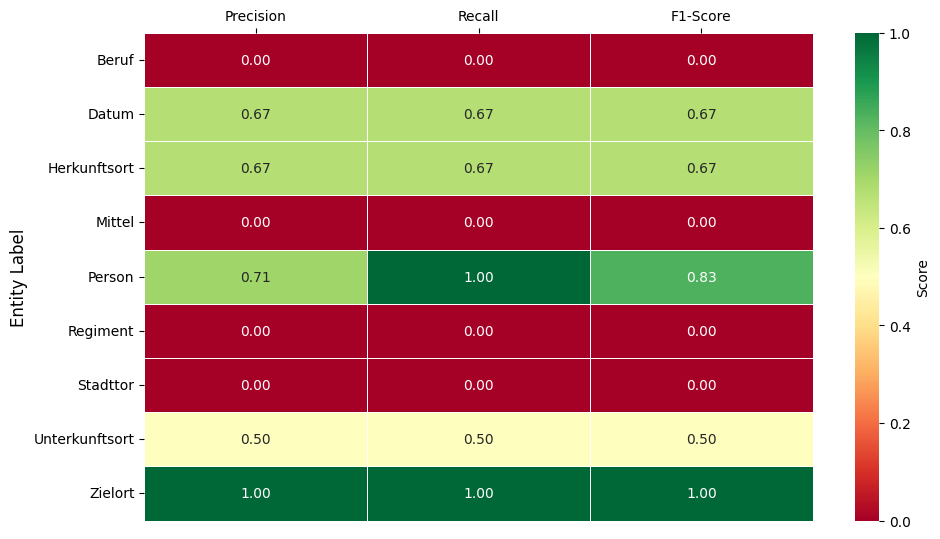

In [65]:
visualize_seqeval_report(report)

# Further planned features (work in progress)

In [ ]:
# Helping functions for easy manual error corrections (documentation of errors in excel file > automatic correction in results)

In [ ]:
# WIP: fast-runs of multiple building block combinations (e.g. import+cleaning+NER+download)